In [1]:
# Quick preview to test the different types of composite scores. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [11]:
df = pd.read_csv("../data/cleaned/analysis_data.csv")

In [25]:
def analyse_by_gov_terciles(df, governance_measure='carbon_tax_governance'):
    """
    Analyze carbon tax effectiveness across governance quality levels
    """
    carbon_tax_data = df[df['tax_type'] > 0].copy()
    analysis_data = carbon_tax_data[carbon_tax_data[governance_measure].notna()].copy()

    analysis_data['governance_tercile'] = pd.qcut(
        analysis_data[governance_measure], 
        q=3, 
        labels=['Low', 'Medium', 'High'],
        duplicates='drop'
    )

    tercile_analysis = analysis_data.groupby('governance_tercile').agg({
        'co2_per_capita_future_trend': ['mean', 'std', 'count'],
        'co2_per_gdp_future_trend': ['mean', 'std', 'count'],
        'tax_price': ['mean', 'std'],
        'years_since_tax': ['mean', 'std'],
        governance_measure: ['mean', 'min', 'max'],
        'country': 'nunique'
    }).round(3)

    print(f"\n📈 Carbon Tax Effectiveness by {governance_measure.title()} Tercile:")
    print(tercile_analysis)

    from scipy import stats

    groups = []
    for tercile in ['Low', 'Medium', 'High']:
        group_data = analysis_data[analysis_data['governance_tercile'] == tercile]['co2_per_capita_future_trend'].dropna()
        if len(group_data) > 0:
            groups.append(group_data)

    if len(groups) >= 2:
        if len(groups) == 2:
            stat, p_value = stats.ttest_ind(groups[0], groups[1])
            test_name = "T-test"
        else:
            stat, p_value = stats.f_oneway(*groups)
            test_name = "ANOVA"

        print(f"\n🧪 {test_name} Results:")
        print(f"   Statistic: {stat:.3f}")
        print(f"   P-value: {p_value:.5f}")
        print(f"   Significant: {'Yes' if p_value < 0.05 else 'No'}")
        
    return tercile_analysis

    

In [27]:
def test_governance_moderation(df, governance_measure='carbon_tax_governance'):
    """
    Test if governance quality moderates carbon tax effectiveness
    """
    model_data = df[
        (df['tax_type'] > 0) & 
        (df[governance_measure].notna()) &
        (df['co2_per_capita_future_trend'].notna()) &
        (df['tax_price'].notna())
    ].copy()

    model_data['tax_price_std'] = (model_data['tax_price'] - model_data['tax_price'].mean()) / model_data['tax_price'].std()
    model_data['governance_std'] = (model_data[governance_measure] - model_data[governance_measure].mean()) / model_data[governance_measure].std()

    base_model = smf.ols(
        'co2_per_capita_future_trend ~ tax_price_std + C(year)',
        data=model_data
    ).fit()

    interaction_model = smf.ols(
        'co2_per_capita_future_trend ~ tax_price_std + governance_std + tax_price_std:governance_std + C(year)',
        data=model_data
    ).fit()

    print(f"\n Base Model (Tax Price Only):")
    print(f"   Tax Price Coefficient: {base_model.params['tax_price_std']:.4f}")
    print(f"   P-value: {base_model.pvalues['tax_price_std']:.3f}")
    print(f"   R-squared: {base_model.rsquared:.3f}")
    
    print(f"\n Interaction Model (Tax Price × Governance):")
    print(f"   Tax Price Coefficient: {interaction_model.params['tax_price_std']:.4f}")
    print(f"   Governance Coefficient: {interaction_model.params['governance_std']:.4f}")
    print(f"   Interaction Coefficient: {interaction_model.params['tax_price_std:governance_std']:.4f}")
    print(f"   Interaction P-value: {interaction_model.pvalues['tax_price_std:governance_std']:.3f}")
    print(f"   R-squared: {interaction_model.rsquared:.3f}")
    
    # Interpretation
    interaction_coef = interaction_model.params['tax_price_std:governance_std']
    interaction_p = interaction_model.pvalues['tax_price_std:governance_std']

    if interaction_p < 0.05:
        if interaction_coef < 0:
            print("Governance ENHANCES carbon tax effectiveness (negative interaction)")
            print("Higher governance quality amplifies emissions reductions from carbon taxes")
        else:
            print("Governance REDUCES carbon tax effectiveness (positive interaction)")
            print("Higher governance quality dampens emissions reductions from carbon taxes")
    else:
        print("No significant moderation effect detected")
        print("Carbon tax effectiveness doesn't vary significantly by governance quality")
    
    return base_model, interaction_model
    

In [14]:
def plot_governance_tax_relationship(df, governance_measure='carbon_tax_governance'):
    """
    Create visualizations of governance-carbon tax relationships
    """
    plot_data = df[
        (df['tax_type'] > 0) & 
        (df[governance_measure].notna()) &
        (df['co2_per_capita_future_trend'].notna())
    ].copy()

    plot_data['governance_tercile'] = pd.qcut(
        plot_data[governance_measure], 
        q=3, 
        labels=['Low', 'Medium', 'High'],
        duplicates='drop'
    )

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    # Plot 1: Governance vs Emissions Trend
    sns.scatterplot(
        data=plot_data, 
        x=governance_measure, 
        y='co2_per_capita_future_trend',
        hue='governance_tercile',
        alpha=0.7,
        ax=axes[0,0]
    )
    axes[0,0].set_title('Governance Quality vs CO₂ Emissions Trend')
    axes[0,0].set_xlabel(governance_measure.replace('_', ' ').title())
    axes[0,0].set_ylabel('CO₂ per Capita Future Trend')

    # Plot 2: Tax Price vs Emissions by Governance Tercile
    sns.scatterplot(
        data=plot_data,
        x='tax_price',
        y='co2_per_capita_future_trend', 
        hue='governance_tercile',
        alpha=0.7,
        ax=axes[0,1]
    )
    axes[0,1].set_title('Carbon Tax Price vs Emissions by Governance Quality')
    axes[0,1].set_xlabel('Carbon Tax Price ($/tonne CO₂)')
    axes[0,1].set_ylabel('CO₂ per Capita Future Trend')

    # Plot 3: Box plot of emissions by governance tercile
    sns.boxplot(
        data=plot_data,
        x='governance_tercile',
        y='co2_per_capita_future_trend',
        ax=axes[1,0]
    )
    axes[1,0].set_title('CO₂ Emissions Trends by Governance Tercile')
    axes[1,0].set_xlabel('Governance Quality Tercile')
    axes[1,0].set_ylabel('CO₂ per Capita Future Trend')

    # Plot 4: Governance distribution
    plot_data[governance_measure].hist(bins=30, ax=axes[1,1], alpha=0.7)
    axes[1,1].set_title(f'{governance_measure.replace("_", " ").title()} Distribution')
    axes[1,1].set_xlabel(governance_measure.replace('_', ' ').title())
    axes[1,1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

In [17]:
tercile_results = analyse_by_gov_terciles(df, 'carbon_tax_governance')


🧪 ANOVA Results:
   Statistic: 11.858
   P-value: 0.00001
   Significant: Yes


C:\Users\willn\AppData\Local\Temp\ipykernel_31228\2809288608.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tercile_analysis = analysis_data.groupby('governance_tercile').agg({


In [28]:
base_model, interaction_model = test_governance_moderation(df, 'carbon_tax_governance')


 Base Model (Tax Price Only):
   Tax Price Coefficient: 0.0022
   P-value: 0.861
   R-squared: 0.144

 Interaction Model (Tax Price × Governance):
   Tax Price Coefficient: 0.0984
   Governance Coefficient: -0.1169
   Interaction Coefficient: -0.0521
   Interaction P-value: 0.061
   R-squared: 0.233
No significant moderation effect detected
Carbon tax effectiveness doesn't vary significantly by governance quality


C:\Users\willn\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


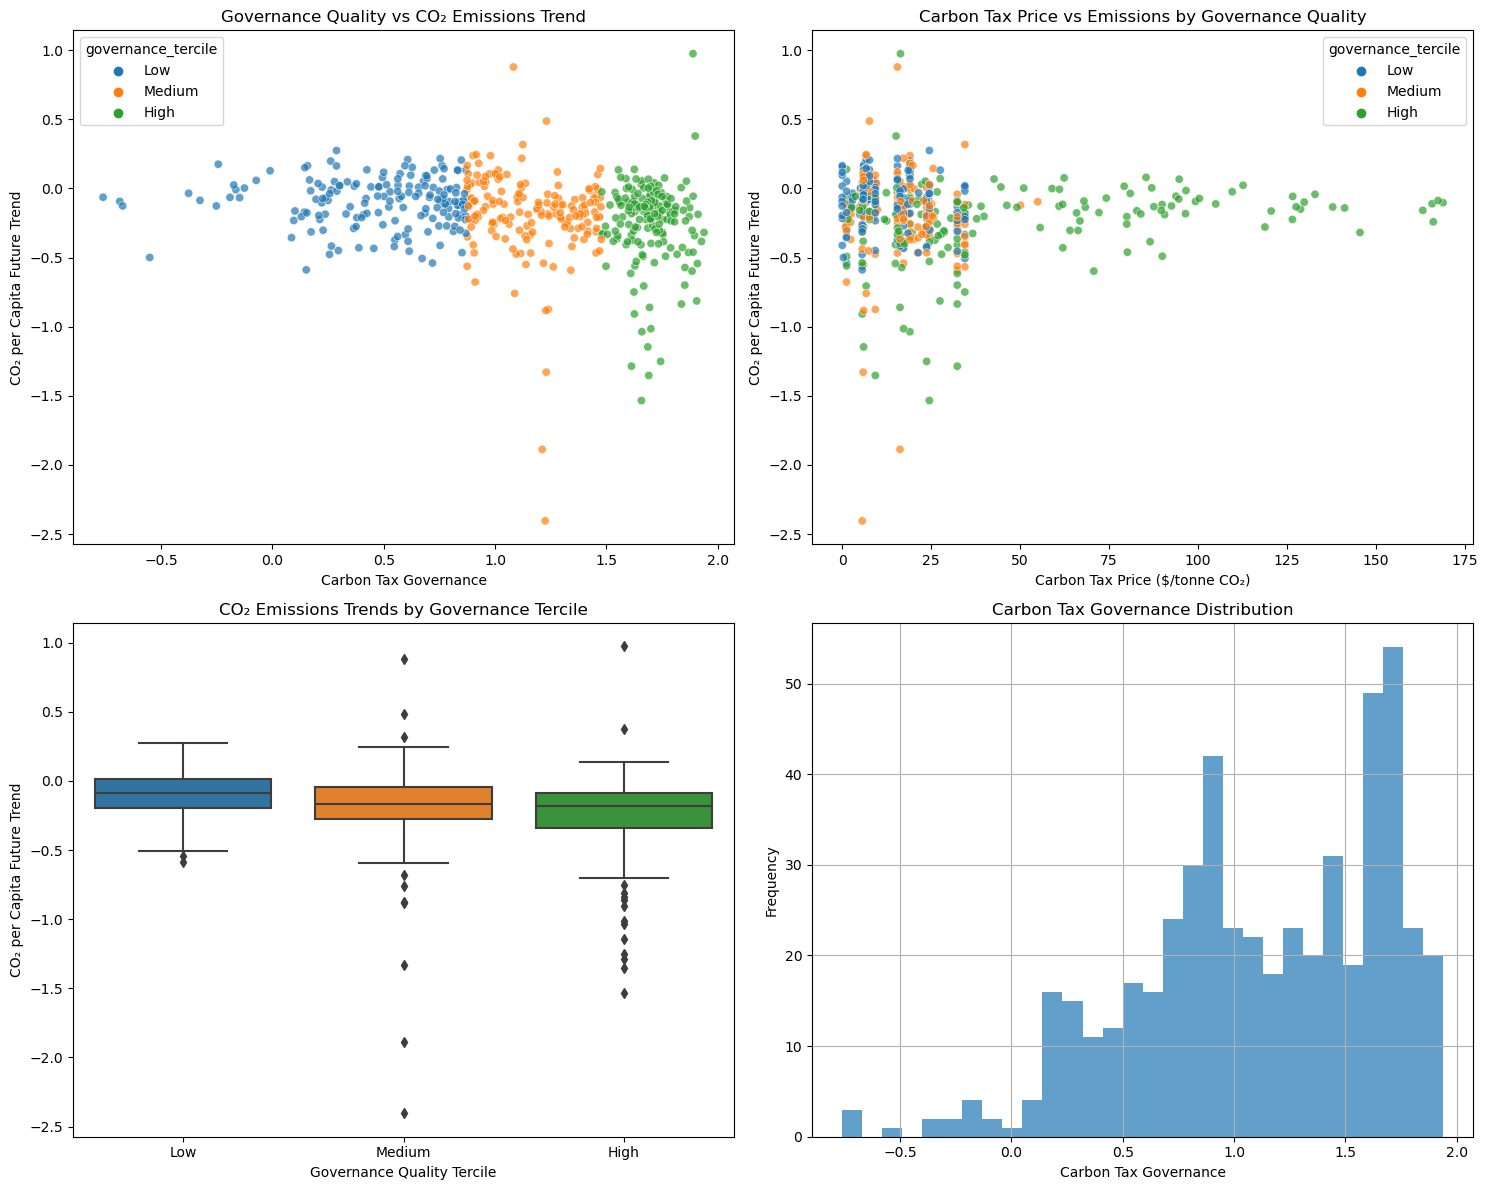

In [19]:
plot_governance_tax_relationship(df, 'carbon_tax_governance')

In [26]:
for measure in ['carbon_tax_governance','implementation_capacity', 'democratic_legitimacy', 'governance_pc1', 'governance_pc2']:
    if measure in df.columns:
        print(f'\n--- {measure} ---')
        analyse_by_gov_terciles(df, measure)


--- carbon_tax_governance ---

📈 Carbon Tax Effectiveness by Carbon_Tax_Governance Tercile:
                   co2_per_capita_future_trend               \
                                          mean    std count   
governance_tercile                                            
Low                                     -0.098  0.174   156   
Medium                                  -0.184  0.322   171   
High                                    -0.246  0.302   177   

                   co2_per_gdp_future_trend              tax_price          \
                                       mean    std count      mean     std   
governance_tercile                                                           
Low                                  -0.011  0.012   156    18.697  20.304   
Medium                               -0.009  0.013   171    21.846  21.038   
High                                 -0.007  0.006   177    48.163  41.878   

                   years_since_tax        carbon_tax_govern

C:\Users\willn\AppData\Local\Temp\ipykernel_31228\2107428028.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tercile_analysis = analysis_data.groupby('governance_tercile').agg({
C:\Users\willn\AppData\Local\Temp\ipykernel_31228\2107428028.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tercile_analysis = analysis_data.groupby('governance_tercile').agg({
C:\Users\willn\AppData\Local\Temp\ipykernel_31228\2107428028.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True 